This notebook applies a stateful LSTM model using PyTorch & Lightning, to get multi-step quantile energy consumption forecasts. 
\
It also performs & demonstrates the necessary data handling & preprocessing steps to get input & output sequences for the LSTM model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import lightning as L
import optuna
import warnings

from lightning.pytorch.callbacks import Callback
from optuna.integration import PyTorchLightningPruningCallback
from src.deep_learning.preprocessing import SequenceScaler, SequenceDataset
from src.deep_learning.quantile_loss import QuantileLoss
from src.deep_learning.lstm import StatefulQuantileLSTM
from src.deep_learning.testing import train_val_split, test_sequences_to_dataframe, plot_actual_predicted, plot_sequence_preds, calculate_metrics
from src.deep_learning.prediction import predictions_to_dataframe

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
random_seed = 1923

In [4]:
# Set Torch settings
torch.set_default_dtype(torch.float32)
torch.set_float32_matmul_precision('medium')
L.seed_everything(random_seed, workers = True)
warnings.filterwarnings("ignore", ".*does not have many workers.*")

Seed set to 1923


In [5]:
# Plot settings
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")

In [6]:
data_dir = "../data/analysis/processed/"

In [7]:
df = pd.read_csv(data_dir + "train_data.csv")
df["time"] = pd.to_datetime(df["time"])

In [8]:
df

,time,consumption_MWh,consumption_lag2,trend,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
0,2018-01-01 02:00:00,24635.32,27412.81,2,7.071068e-01,7.071068e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
1,2018-01-01 03:00:00,23872.12,26324.39,3,8.660254e-01,5.000000e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
2,2018-01-01 04:00:00,23194.89,24635.32,4,9.659258e-01,2.588190e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
3,2018-01-01 05:00:00,23071.96,23872.12,5,1.000000e+00,6.123234e-17,7.818315e-01,0.62349,5.000000e-01,0.866025
4,2018-01-01 06:00:00,23267.90,23194.89,6,9.659258e-01,-2.588190e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...
52577,2023-12-31 19:00:00,35090.93,34549.42,52579,-8.660254e-01,5.000000e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000
52578,2023-12-31 20:00:00,33310.94,36193.59,52580,-7.071068e-01,7.071068e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000
52579,2023-12-31 21:00:00,32083.96,35090.93,52581,-5.000000e-01,8.660254e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000
52580,2023-12-31 22:00:00,30469.49,33310.94,52582,-2.588190e-01,9.659258e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000


## Data prep: Getting input & output sequences

We will create a "shifted dataset" where each row at time T contains the following columns:
- Target value at T (consumption lead T+1),
- Past value at T (consumption lag T-2),
- Time covariates at T.

In [9]:
# Get shifted dataset, drop last row due to unknown target
df_shifted = df.copy()
df_shifted["consumption_MWh"] = df_shifted.consumption_MWh.shift(-1)
df_shifted = df_shifted.dropna()

In [10]:
df_shifted

,time,consumption_MWh,consumption_lag2,trend,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
0,2018-01-01 02:00:00,23872.12,27412.81,2,0.707107,7.071068e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
1,2018-01-01 03:00:00,23194.89,26324.39,3,0.866025,5.000000e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
2,2018-01-01 04:00:00,23071.96,24635.32,4,0.965926,2.588190e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
3,2018-01-01 05:00:00,23267.90,23872.12,5,1.000000,6.123234e-17,7.818315e-01,0.62349,5.000000e-01,0.866025
4,2018-01-01 06:00:00,23875.44,23194.89,6,0.965926,-2.588190e-01,7.818315e-01,0.62349,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...
52576,2023-12-31 18:00:00,35090.93,32670.06,52578,-0.965926,2.588190e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000
52577,2023-12-31 19:00:00,33310.94,34549.42,52579,-0.866025,5.000000e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000
52578,2023-12-31 20:00:00,32083.96,36193.59,52580,-0.707107,7.071068e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000
52579,2023-12-31 21:00:00,30469.49,35090.93,52581,-0.500000,8.660254e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000


Every input sequence will be the last 72 hours before 16:00, and every output sequence will be the next 32 hours after 16:00.

In [11]:
# Define fixed model parameters
n_steps = len(df_shifted) 
input_length = 72 # T-L to T hours as input
input_dims = 8 # Consumption lag 2, trend, 6 cyclical columns as features
output_length = 32 # We are only interested in predicting T+8 to 32, but we have to predict from T+1 because we need hidden states at each time step.
horizon_start = 0 # Output step to start loss calculation from
quantiles = [0.025, 0.5, 0.975] # Quantiles to predict

In [12]:
# Find the index of the first 16:00 row in the data, where the index is bigger than input_length - 1. This will be the first T.
first_t = df_shifted.loc[(df_shifted.time.dt.hour == 16) & (df_shifted.index >= input_length - 1)].index.values[0]

In [13]:
first_t 

86

In [14]:
# Find the index of the last 16:00 row in the data, with 32 time steps after it. This will be the last T.
last_t = df_shifted.loc[(df_shifted.time.dt.hour == 16) & (df_shifted.index + output_length - 1 <= df.index.values[-1])].index.values[-2]

In [15]:
last_t 

52526

Each input sequence will contain the following:
- Consumption lag 2 at [T - input_length, T] (past targets),
- Time covariates at [T - input_length + 1, T+1 ] (future known covariates).

In [16]:
# One input sequence
input_seq = pd.concat([
    df_shifted.iloc[(first_t - input_length):first_t, 0], # Time
    df_shifted.iloc[(first_t - input_length):first_t, 2], # Past target
    df_shifted.shift(-1).iloc[(first_t - input_length):(first_t), 3:] # Future known covariates
], axis = 1)

Each output sequence will contain the following:
- Consumption at [T+1, T + output_length] (future targets),
- Time covariates at [T+2, T + output_length + 1] (future known covariates for prediction steps after T+1)

In [17]:
# One output sequence
output_seq = pd.concat([
    df_shifted.iloc[first_t:(first_t + output_length), 0], # Time 
    df_shifted.iloc[first_t:(first_t + output_length), 1], # Future target
    df_shifted.shift(-1).iloc[first_t:(first_t + output_length), 3:] # Future known covariates
], axis = 1)

In [18]:
input_seq.iloc[-5:]

,time,consumption_lag2,trend,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
81,2018-01-04 11:00:00,39641.36,84.0,-0.258819,-0.965926,-0.433884,-0.900969,0.5,0.866025
82,2018-01-04 12:00:00,40593.83,85.0,-0.500000,-0.866025,-0.433884,-0.900969,0.5,0.866025
83,2018-01-04 13:00:00,40955.07,86.0,-0.707107,-0.707107,-0.433884,-0.900969,0.5,0.866025
84,2018-01-04 14:00:00,39505.55,87.0,-0.866025,-0.500000,-0.433884,-0.900969,0.5,0.866025
85,2018-01-04 15:00:00,39635.29,88.0,-0.965926,-0.258819,-0.433884,-0.900969,0.5,0.866025


In [19]:
output_seq[:5]

,time,consumption_MWh,trend,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
86,2018-01-04 16:00:00,40487.65,89.0,-1.000000,-1.836970e-16,-0.433884,-0.900969,0.5,0.866025
87,2018-01-04 17:00:00,39936.25,90.0,-0.965926,2.588190e-01,-0.433884,-0.900969,0.5,0.866025
88,2018-01-04 18:00:00,38772.68,91.0,-0.866025,5.000000e-01,-0.433884,-0.900969,0.5,0.866025
89,2018-01-04 19:00:00,38113.86,92.0,-0.707107,7.071068e-01,-0.433884,-0.900969,0.5,0.866025
90,2018-01-04 20:00:00,36758.94,93.0,-0.500000,8.660254e-01,-0.433884,-0.900969,0.5,0.866025


In [20]:
df_shifted.iloc[81:90]

,time,consumption_MWh,consumption_lag2,trend,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
81,2018-01-04 11:00:00,39505.55,39641.36,83,1.224647e-16,-1.000000e+00,-0.433884,-0.900969,0.5,0.866025
82,2018-01-04 12:00:00,39635.29,40593.83,84,-2.588190e-01,-9.659258e-01,-0.433884,-0.900969,0.5,0.866025
83,2018-01-04 13:00:00,39952.75,40955.07,85,-5.000000e-01,-8.660254e-01,-0.433884,-0.900969,0.5,0.866025
84,2018-01-04 14:00:00,39649.45,39505.55,86,-7.071068e-01,-7.071068e-01,-0.433884,-0.900969,0.5,0.866025
85,2018-01-04 15:00:00,40063.17,39635.29,87,-8.660254e-01,-5.000000e-01,-0.433884,-0.900969,0.5,0.866025
86,2018-01-04 16:00:00,40487.65,39952.75,88,-9.659258e-01,-2.588190e-01,-0.433884,-0.900969,0.5,0.866025
87,2018-01-04 17:00:00,39936.25,39649.45,89,-1.000000e+00,-1.836970e-16,-0.433884,-0.900969,0.5,0.866025
88,2018-01-04 18:00:00,38772.68,40063.17,90,-9.659258e-01,2.588190e-01,-0.433884,-0.900969,0.5,0.866025
89,2018-01-04 19:00:00,38113.86,40487.65,91,-8.660254e-01,5.000000e-01,-0.433884,-0.900969,0.5,0.866025


In the input sequence, we pair every past target value at T with the future covariates at T+1.
\
In the output sequence, we pair every future target value at T+1 with the future covariates at T+2.

This is because the future target at T+1 and the future covariates at T+2 will be the past target & future covariates in the next prediction step. 
\
LSTMs and RNNs can only forecast 1 step at a time as they need hidden & cell states from the previous step. 
\
For validation & prediciton steps, we will replace the future targets after T+1 with predicitons from the previous step, as these will be unknown values at real prediciton time.

During training, we still use the real target values for all prediciton steps "in hindsight", as training with predictions as the target may mislead the model. In a real life scenario, we'd have the "hindsight" values available in the historic data, just like we do here.

In [21]:
n_sequences = (last_t - first_t) // 24 + 1 # Number of 16:00 rows followed by a sufficient input / output sequence
print("Number of possible sequences: " + f"{n_sequences}")

Number of possible sequences: 2186


In [21]:
# Initialize lists of sequences
input_sequences = []
output_sequences = []

# Get all sequences
for t in range(first_t, last_t + 1, 24):

    # Get input sequence
    new_input = pd.concat([
        df_shifted.iloc[(t - input_length):t, 0], # Time
        df_shifted.iloc[(t - input_length):t, 2], # Past target
        df_shifted.shift(-1).iloc[(t - input_length):t, 3:] # Future known covariates
        ], axis = 1)
    new_input = new_input.set_index("time")

    # Get output sequence
    new_output = pd.concat([
        df_shifted.iloc[t:(t + output_length), 0], # Time 
        df_shifted.iloc[t:(t + output_length), 1], # Future target
        df_shifted.shift(-1).iloc[t:(t + output_length), 3:] # Future known covariates
        ], axis = 1)
    new_output = new_output.set_index("time")

    # Concatenate to arrays of sequences
    input_sequences.append(new_input)
    output_sequences.append(new_output)

In [22]:
len(input_sequences)

2186

In [23]:
len(output_sequences)

2186

## Preprocessing: Custom scaler, Torch datasets & dataloaders

In a stateful LSTM, the last timestep's hidden & cell state for observation 1 in batch 1 will be used as the initial hidden & cell state for observation 1 in batch 2.

Because of this, we need batches of constant size through training, val. and testing data. We'll divide the lengths of each data fold with the batch size, drop the remainder from the start of the training fold & the end of the val. & test folds.
\
The data splitter is implemented in `src.deep_learning.testing`.

In [24]:
batch_size = 64
train_fraction = 0.8

In [25]:
# Train - test split
train_input, train_output, test_input, test_output = train_val_split(
    input_sequences, 
    output_sequences,
    train_fraction = train_fraction,
    batch_size = batch_size
)

In [26]:
# Train - val split for tuning
tr_input, tr_output, val_input, val_output = train_val_split(
    train_input,
    train_output,
    train_fraction = train_fraction,
    batch_size = batch_size
)

In [27]:
# First testing set output sequence
test_input[0]

,consumption_lag2,trend,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
time,,,,,,,,
2022-10-15 16:00:00,36626.13,41969.0,-1.000000,-1.836970e-16,-0.781831,0.623490,-0.866025,0.5
2022-10-15 17:00:00,35781.60,41970.0,-0.965926,2.588190e-01,-0.781831,0.623490,-0.866025,0.5
2022-10-15 18:00:00,35326.54,41971.0,-0.866025,5.000000e-01,-0.781831,0.623490,-0.866025,0.5
2022-10-15 19:00:00,35455.95,41972.0,-0.707107,7.071068e-01,-0.781831,0.623490,-0.866025,0.5
2022-10-15 20:00:00,36296.82,41973.0,-0.500000,8.660254e-01,-0.781831,0.623490,-0.866025,0.5
...,...,...,...,...,...,...,...,...
2022-10-18 11:00:00,38067.75,42036.0,-0.258819,-9.659258e-01,0.974928,-0.222521,-0.866025,0.5
2022-10-18 12:00:00,38820.67,42037.0,-0.500000,-8.660254e-01,0.974928,-0.222521,-0.866025,0.5
2022-10-18 13:00:00,39206.44,42038.0,-0.707107,-7.071068e-01,0.974928,-0.222521,-0.866025,0.5


In [28]:
# First prediction point in testing data
test_output[0].index[0]

Timestamp('2022-10-18 16:00:00')

We have to scale the past consumption & trend values in the input sequences, and the future consumption & trend values in the output sequences, because they'll be the past values as the forecast horizon expands. We also need the ability to backtransform the network's final predictions accordingly.

This can be done with the custom `SequenceScaler` implemented in `src.deep_learning.preprocessing`.

The scaled data is then converted into Torch tensors using `SequenceDataset`.

In [29]:
# Scale validation data & create Torch datasets
scaler_val = SequenceScaler()
_ = scaler_val.fit(tr_input, tr_output)
tr_data = SequenceDataset(scaler_val.transform(tr_input), scaler_val.transform(tr_output))
val_data = SequenceDataset(scaler_val.transform(val_input), scaler_val.transform(val_output))

# Scale testing data & create Torch datasets
scaler_test = SequenceScaler()
_ = scaler_test.fit(train_input, train_output)
train_data = SequenceDataset(scaler_test.transform(train_input), scaler_test.transform(train_output))
test_data = SequenceDataset(scaler_test.transform(test_input), scaler_test.transform(test_output))

In [30]:
# Create Torch dataloaders
num_workers = 0
shuffle = False

# Training data at validation step
tr_loader = torch.utils.data.DataLoader(
    tr_data, batch_size = batch_size, num_workers = num_workers, shuffle = shuffle)

# Training data at testing step
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size = batch_size, num_workers = num_workers, shuffle = shuffle)

# Validation & testing data
val_loader = torch.utils.data.DataLoader(
    val_data, batch_size = batch_size, num_workers = num_workers, shuffle = shuffle)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size = batch_size, num_workers = num_workers, shuffle = shuffle)

## Model definition

The `StatefulQuantileLSTM` model, and the `QuantileLoss` function are both implemented in `src.deep_learning`.

## Hyperparameter tuning with Optuna

In [ ]:
# Define tuning parameters
tol = 0.002 # Change in MAE to avoid early stopping
patience = 5 # N. of rounds with no improvement before early stopping

In [ ]:
# Define Optuna objective
def objective_lstm(trial):

    # Define search space
    learning_rate = trial.suggest_float("learning_rate", 5e-4, 5e-2) # 0.0005 to 0.05
    lr_decay = trial.suggest_float("lr_decay", 0.9, 1)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    hidden_size = 2 ** trial.suggest_int("hidden_size_pw", 2, 6) # 4 to 64, powers of 2
    dropout_rate = trial.suggest_float("dropout_rate", 0, 0.1)

    # Create hyperparameters dict
    hyperparameters_dict = {
        "output_length": output_length,
        "input_size": input_dims,
        "horizon_start": horizon_start,
        "quantiles": quantiles,
        "learning_rate": learning_rate,
        "lr_decay": lr_decay,
        "num_layers": num_layers,
        "hidden_size": hidden_size,
        "dropout_rate": dropout_rate
    }

    # Create early stop callback
    callback_earlystop = L.pytorch.callbacks.EarlyStopping(
        monitor = "val_loss", 
        mode = "min", 
        min_delta = tol, 
        patience = patience
    )

    # Create pruning callback
    callback_pruner = PyTorchLightningPruningCallback(trial, monitor = "val_loss")

    # Create trainer
    trainer = L.Trainer(
        max_epochs = 50,
        accelerator = "gpu",
        devices = "auto",
        precision = "16-mixed",
        callbacks = [callback_earlystop, callback_pruner],
        enable_model_summary = False,
        logger = False,
        enable_progress_bar = False,
        enable_checkpointing = False
    )

    # Create & train model
    model = StatefulQuantileLSTM(hyperparameters_dict)
    trainer.fit(model, tr_loader, val_loader)

    # Retrieve best val score and n. of epochs
    score = callback_earlystop.best_score.cpu().numpy()
    epoch = trainer.current_epoch - callback_earlystop.wait_count # Starts from 1

    # Report best n. of epochs to study
    trial.set_user_attr("n_epochs", epoch)
  
    return score

In [ ]:
# Create study
study_lstm = optuna.create_study(
  sampler = optuna.samplers.TPESampler(seed = random_seed),
  pruner = optuna.pruners.HyperbandPruner(),
  study_name = "tune_lstm",
  direction = "minimize"
)

In [ ]:
# Optimize study
study_lstm.optimize(objective_lstm, n_trials = 250, show_progress_bar = True)

In [ ]:
# Retrieve and export trials
export_trial_no = "1"
trials_lstm = study_lstm.trials_dataframe().sort_values("value", ascending = True)
trials_lstm.to_csv(f"../data/tuning_logs/trials_lstm{export_trial_no}.csv", index = False)

## Model testing

In [31]:
# Import best trial
import_trial_no = "1"
best_trial_lstm = pd.read_csv(f"../data/tuning-logs/trials_lstm{import_trial_no}.csv").iloc[0,]

In [32]:
best_trial_lstm

number                                                  140
value                                              0.764235
datetime_start                   2024-04-23 11:36:05.971827
datetime_complete                2024-04-23 11:36:45.745790
duration                             0 days 00:00:39.773963
params_dropout_rate                                0.096567
params_hidden_size_pw                                     3
params_learning_rate                                0.01235
params_lr_decay                                    0.916413
params_num_layers                                         1
user_attrs_n_epochs                                     9.0
system_attrs_completed_rung_0                      1.028064
system_attrs_completed_rung_1                      0.876199
system_attrs_completed_rung_2                           NaN
state                                              COMPLETE
Name: 0, dtype: object

In [33]:
# Create hyperparameters dict
hyperparameters_dict = {
    "output_length": output_length,
    "input_size": input_dims,
    "horizon_start": horizon_start,
    "quantiles": quantiles,
    "learning_rate": best_trial_lstm["params_learning_rate"],
    "lr_decay": best_trial_lstm["params_lr_decay"],
    "num_layers": best_trial_lstm["params_num_layers"],
    "hidden_size": int(2 ** best_trial_lstm["params_hidden_size_pw"]),
    "dropout_rate": best_trial_lstm["params_dropout_rate"]
}

In [34]:
# Create trainer
trainer = L.Trainer(
    max_epochs = int(best_trial_lstm["user_attrs_n_epochs"]),
    accelerator = "gpu",
    devices = "auto",
    precision = "16-mixed",
    enable_model_summary = True,
    logger = False,
    enable_progress_bar = True,
    enable_checkpointing = False
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [35]:
# Create & train model
model = StatefulQuantileLSTM(hyperparameters_dict)
trainer.fit(model, train_loader)

C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\DeepLearningEnergyForecasting\venv\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type   | Params | Mode 
------------------------------------------------
0 | lstm         | LSTM   | 576    | train
1 | output_layer | Linear | 27     | train
------------------------------------------------
603       Trainable params
0         Non-trainable params
603       Total params
0.002     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=9` reached.


In [36]:
# Make predictions on test data & backtransform scaled values
preds_raw = trainer.predict(model, test_loader)
preds_raw = torch.cat(preds_raw, dim = 0).cpu().numpy().astype(np.float32)
preds = scaler_test.backtransform_preds(preds_raw)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

In [41]:
# Combine back prediction sequences with times
df_preds = predictions_to_dataframe(preds, test_output)

In [42]:
df_preds

,time,pred_low,pred_point,pred_high
0,2022-10-18 16:00:00,37178.382812,38880.500000,40734.902344
1,2022-10-18 17:00:00,37701.546875,39354.539062,41073.851562
2,2022-10-18 18:00:00,37948.390625,39531.382812,41127.886719
3,2022-10-18 19:00:00,37828.039062,39320.156250,40788.937500
4,2022-10-18 20:00:00,37292.593750,38669.273438,40010.335938
...,...,...,...,...
12283,2023-11-06 19:00:00,36954.871094,38256.636719,39703.316406
12284,2023-11-06 20:00:00,36269.605469,37437.507812,38669.273438
12285,2023-11-06 21:00:00,35175.230469,36191.621094,37218.910156
12286,2023-11-06 22:00:00,33721.339844,34588.976562,35437.582031


In [43]:
# Combine back testing output sequences with input sequences & times
df_test = test_sequences_to_dataframe(test_input, test_output)

In [44]:
df_test

,time,consumption_MWh,sequence
0,2022-10-15 16:00:00,36626.13,input
1,2022-10-15 17:00:00,35781.60,input
2,2022-10-15 18:00:00,35326.54,input
3,2022-10-15 19:00:00,35455.95,input
4,2022-10-15 20:00:00,36296.82,input
...,...,...,...
12283,2023-11-06 19:00:00,37942.64,output
12284,2023-11-06 20:00:00,36946.90,output
12285,2023-11-06 21:00:00,35721.14,output
12286,2023-11-06 22:00:00,33987.09,output


<Axes: title={'center': 'Model: Stateful LSTM'}, xlabel='time', ylabel='consumption_MWh'>

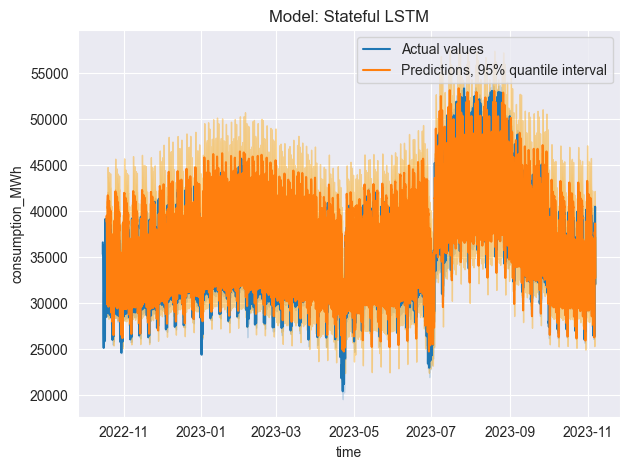

In [47]:
# Predicted vs. actual plot, hourly, entire test period
_ = plot_actual_predicted(df_test, df_preds, "Stateful LSTM")

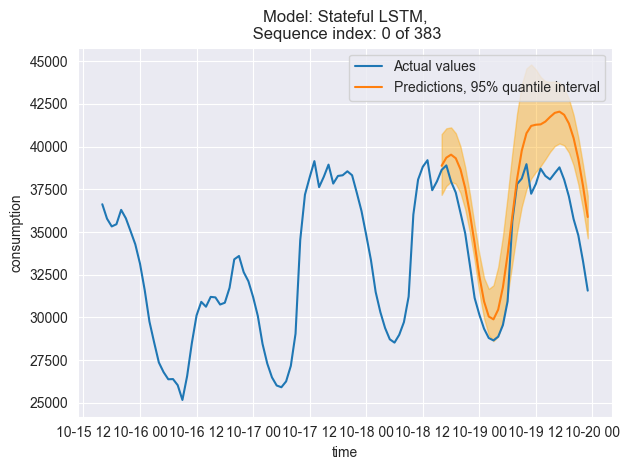

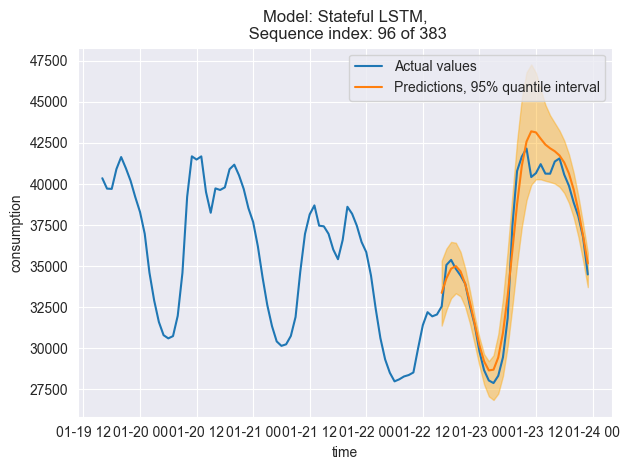

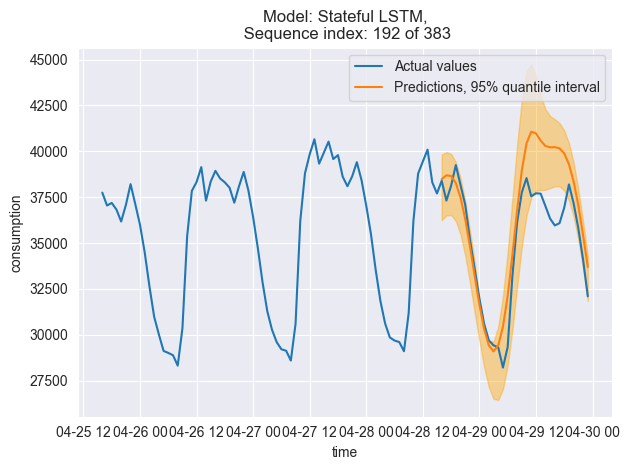

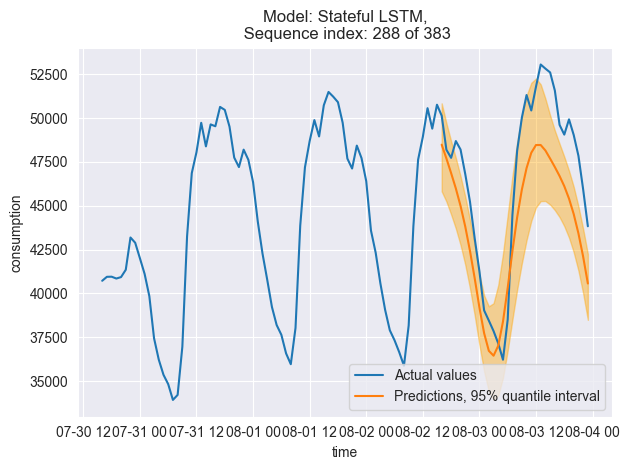

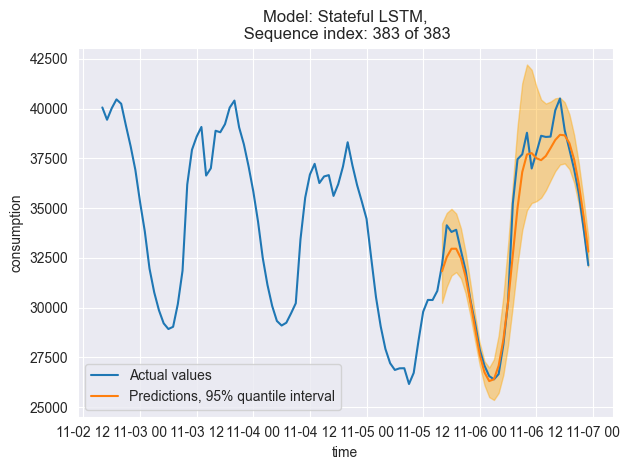

In [51]:
# Predicted vs. actual plots, zoomed in
indices = [i for i in range(0, len(test_output), len(test_output) // 4)]
indices.append(len(test_output) - 1)
for idx in indices:
    _ = plot_sequence_preds(preds, test_input, test_output, "Stateful LSTM", sequence_index = idx)

In [52]:
# Calculate performance metrics: MAE, RMSLE, MAPE, pinball loss
calculate_metrics(df_test, df_preds, "Stateful LSTM")

,Model: Stateful LSTM
"MAPE, point",6.5408
"RMSLE, point",0.0843
"MAE, point",2345.9338
"Pinball loss, q: 2.5%",656.8069
"Pinball loss, q: 50.0%",1172.9669
"Pinball loss, q: 97.5%",300.4510


Keep in mind that for the median quantile, pinball loss equals MAE / 2.